In [184]:
import pathlib
import os
import pandas as pd
import numpy as np
import functools
import operator

import scipy.stats as stats
from matplotlib import pyplot as plt

import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, KFold, cross_val_score
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegressionCV, LinearRegression
from sklearn.feature_selection import RFECV

## Data Cleaning & Organization

In [185]:
basicStats = pd.concat(
    (pd.read_csv(f).assign(Season = os.path.basename(f).removesuffix(".csv")) for f in (pathlib.Path()/"Data"/"Basic_Stats").glob("*.csv")), 
    ignore_index = True
)
basicStats

,Rk,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,...,STL,BLK,TOV,PF,PTS,Unnamed: 29,ORtg,DRtg,Player-additional,Season
0,1,Mahmoud Abdul-Rauf,PG,28,SAC,31,0,530,10.1,26.8,...,1.6,0.1,1.9,3.0,22.3,NaN,90.0,110.0,abdulma02,1997-1998
1,2,Tariq Abdul-Wahad,SG,23,SAC,59,16,959,7.8,19.4,...,1.9,0.7,3.5,4.4,20.4,NaN,91.0,108.0,abdulta01,1997-1998
2,3,Shareef Abdur-Rahim,SF,21,VAN,82,82,2950,11.5,23.8,...,1.6,1.3,4.5,3.6,32.3,NaN,109.0,112.0,abdursh01,1997-1998
3,4,Cory Alexander,PG,24,TOT,60,22,1298,7.1,16.6,...,2.9,0.5,4.6,4.1,20.2,NaN,103.0,106.0,alexaco01,1997-1998
4,4,Cory Alexander,PG,24,SAS,37,3,501,6.5,15.7,...,2.7,0.5,5.1,5.7,17.9,NaN,94.0,100.0,alexaco01,1997-1998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22048,438,Dorell Wright,SF,24,MIA,72,1,1496,6.9,15.0,...,1.9,1.1,1.9,3.4,18.3,NaN,114.0,104.0,wrighdo01,2009-2010
22049,439,Julian Wright,SF,22,NOH,68,14,871,6.9,13.8,...,1.7,1.1,2.6,2.7,15.4,NaN,101.0,110.0,wrighju01,2009-2010
22050,440,Nick Young,SG,24,WAS,74,23,1421,8.6,20.6,...,1.0,0.3,2.1,5.4,23.6,NaN,104.0,113.0,youngni01,2009-2010
22051,441,Sam Young,SF,24,MEM,80,1,1321,8.7,19.3,...,1.3,0.8,3.7,4.1,23.1,NaN,102.0,112.0,youngsa01,2009-2010


In [186]:
advStats = pd.concat(
    (pd.read_csv(f).assign(Season = os.path.basename(f).removesuffix(".csv")) for f in (pathlib.Path()/"Data"/"Advanced_Stats").glob("*.csv")), 
    ignore_index = True
)
advStats

,Rk,Player,Pos,Age,Tm,G,MP,PER,TS%,3PAr,...,DWS,WS,WS/48,Unnamed: 24,OBPM,DBPM,BPM,VORP,Player-additional,Season
0,1,Mahmoud Abdul-Rauf,PG,28,SAC,31,530,10.5,0.405,0.114,...,0.2,-0.3,-0.025,NaN,-3.2,-1.5,-4.7,-0.4,abdulma02,1997-1998
1,2,Tariq Abdul-Wahad,SG,23,SAC,59,959,10.1,0.456,0.053,...,0.6,-0.2,-0.008,NaN,-3.6,-1.2,-4.8,-0.7,abdulta01,1997-1998
2,3,Shareef Abdur-Rahim,SF,21,VAN,82,2950,21.1,0.562,0.038,...,0.6,6.9,0.113,NaN,3.4,-1.8,1.6,2.6,abdursh01,1997-1998
3,4,Cory Alexander,PG,24,TOT,60,1298,15.2,0.548,0.440,...,1.2,2.2,0.081,NaN,0.4,0.1,0.5,0.8,alexaco01,1997-1998
4,4,Cory Alexander,PG,24,SAS,37,501,11.1,0.512,0.441,...,0.8,0.7,0.065,NaN,-2.3,1.1,-1.2,0.1,alexaco01,1997-1998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22048,438,Dorell Wright,SF,24,MIA,72,1496,14.5,0.567,0.375,...,2.2,4.3,0.137,NaN,0.7,1.2,1.8,1.5,wrighdo01,2009-2010
22049,439,Julian Wright,SF,22,NOH,68,871,11.8,0.518,0.026,...,0.6,0.8,0.044,NaN,-1.6,-0.5,-2.1,0.0,wrighju01,2009-2010
22050,440,Nick Young,SG,24,WAS,74,1421,10.7,0.519,0.305,...,0.5,1.4,0.046,NaN,-2.0,-1.7,-3.7,-0.6,youngni01,2009-2010
22051,441,Sam Young,SF,24,MEM,80,1321,13.0,0.518,0.113,...,0.7,1.2,0.044,NaN,-1.5,-1.7,-3.1,-0.4,youngsa01,2009-2010


In [187]:
dpoyVoting = pd.concat(
    (pd.read_excel(f, header = 1).assign(Season = os.path.basename(f).removesuffix(".xlsx")) for f in (pathlib.Path()/"Data"/"DPOY_Voting").glob("*.xlsx")), 
    ignore_index = True
)
dpoyVoting

,Rank,Player,Age,Tm,First,Pts Won,Pts Max,Share,G,MP,...,BLK,FG%,3P%,FT%,WS,WS/48,DWS,DBPM,DRtg,Season
0,1,Dikembe Mutombo,34,TOT,48,48,123,0.390,75,34.5,...,2.7,0.484,NaN,0.725,8.1,0.151,4.7,1.3,97,2000-2001
1,2,Kevin Garnett,24,MIN,26,26,123,0.211,81,39.5,...,1.8,0.477,0.288,0.764,11.8,0.176,4.8,1.4,99,2000-2001
2,3,Tim Duncan,24,SAS,14,14,123,0.114,82,38.7,...,2.3,0.499,0.259,0.618,13.2,0.200,7.1,1.8,94,2000-2001
3,4,Doug Christie,30,SAC,9,9,123,0.073,81,36.3,...,0.6,0.395,0.376,0.897,8.7,0.141,4.4,2.3,99,2000-2001
4,5T,David Robinson,35,SAS,6,6,123,0.049,80,29.6,...,2.5,0.486,0.000,0.747,12.1,0.246,5.7,2.7,92,2000-2001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
570,21,Thabo Sefolosha,26,OKC,0,4,600,0.007,79,25.9,...,0.5,0.471,0.275,0.747,4.1,0.097,2.5,1.9,106,2010-2011
571,22,Andrew Bynum,23,LAL,0,3,600,0.005,54,27.8,...,2.0,0.574,NaN,0.660,6.6,0.210,2.8,1.4,100,2010-2011
572,23T,Kenyon Martin,33,DEN,0,2,600,0.003,48,25.7,...,0.7,0.511,0.222,0.583,2.7,0.104,1.6,1.7,105,2010-2011
573,23T,Gerald Wallace,28,TOT,0,2,600,0.003,71,37.9,...,0.9,0.454,0.333,0.746,6.2,0.111,3.6,1.1,105,2010-2011


In [188]:
expStand = pd.concat(
    (pd.read_csv(f, header = 1).assign(Season = os.path.basename(f).removesuffix(".csv")) for f in (pathlib.Path()/"Data"/"Standings").glob("*.csv")), 
    ignore_index = True
)
expStand

,Rk,Team,Overall,Home,Road,E,W,A,C,M,...,Feb,Mar,Apr,Season,SE,NW,SW,May,Jul,Aug
0,1,Chicago Bulls,62-20,37-4,25-16,42-12,20-8,21-5,21-7,10-4,...,10-3,13-1,6-3,1997-1998,NaN,NaN,NaN,NaN,NaN,NaN
1,2,Utah Jazz,62-20,36-5,26-15,24-6,38-14,11-3,13-3,22-2,...,9-2,15-2,9-2,1997-1998,NaN,NaN,NaN,NaN,NaN,NaN
2,3,Los Angeles Lakers,61-21,33-8,28-13,19-11,42-10,6-8,13-3,26-2,...,7-5,13-4,9-1,1997-1998,NaN,NaN,NaN,NaN,NaN,NaN
3,4,Seattle SuperSonics,61-21,35-6,26-15,22-8,39-13,10-4,12-4,20-8,...,8-3,11-5,7-3,1997-1998,NaN,NaN,NaN,NaN,NaN,NaN
4,5,Indiana Pacers,58-24,32-9,26-15,41-13,17-11,22-4,19-9,9-5,...,8-5,11-5,8-2,1997-1998,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1151,26,Golden State Warriors,26-56,18-23,8-33,11-19,15-37,7-3,3-7,NaN,...,4-8,4-12,5-3,2009-2010,1-9,6-12,4-14,NaN,NaN,NaN
1152,27,Washington Wizards,26-56,15-26,11-30,18-34,8-22,10-8,5-13,NaN,...,5-6,1-16,4-4,2009-2010,3-13,3-7,2-8,NaN,NaN,NaN
1153,28,Sacramento Kings,25-57,18-23,7-34,9-21,16-36,4-6,4-6,NaN,...,4-9,4-13,1-5,2009-2010,1-9,7-11,4-14,NaN,NaN,NaN
1154,29,Minnesota Timberwolves,15-67,10-31,5-36,7-23,8-44,4-6,1-9,NaN,...,3-9,1-13,0-7,2009-2010,2-8,3-13,2-16,NaN,NaN,NaN


In [189]:
teamMappings = {
    "Atlanta Hawks": "ATL",
    "Boston Celtics": "BOS",
    "Brooklyn Nets": "BRK",
    "Charlotte Bobcats": "CHA",
    "Charlotte Hornets": "CHO", 
    "Chicago Bulls": "CHI",
    "Cleveland Cavaliers": "CLE", 
    "Dallas Mavericks": "DAL",
    "Denver Nuggets": "DEN",
    "Detroit Pistons": "DET",
    "Golden State Warriors": "GSW",
    "Houston Rockets": "HOU",
    "Indiana Pacers": "IND",
    "Kansas City Kings": "KCK",
    "Los Angeles Clippers": "LAC",
    "Los Angeles Lakers": "LAL",
    "Memphis Grizzlies": "MEM",
    "Miami Heat": "MIA",
    "Milwaukee Bucks": "MIL",
    "Minnesota Timberwolves": "MIN",
    "New Jersey Nets": "NJN",
    "New Orleans Hornets" : "NOH",
    "New Orleans Pelicans": "NOP",
    "New Orleans/Oklahoma City Hornets": "NOK",
    "New York Knicks": "NYK",
    "Oklahoma City Thunder": "OKC",
    "Orlando Magic": "ORL",
    "Philadelphia 76ers": "PHI",
    "Phoenix Suns": "PHO",
    "Portland Trail Blazers": "POR",
    "Sacramento Kings": "SAC",
    "San Antonio Spurs": "SAS",
    "San Diego Clippers": "SDC",
    "Seattle SuperSonics": "SEA",
    "Toronto Raptors": "TOR",
    "Utah Jazz": "UTA",
    "Vancouver Grizzlies": "VAN",
    "Washington Bullets": "WSB",
    "Washington Wizards": "WAS"
}


In [190]:
expStand["Tm"] = expStand["Team"].map(teamMappings)
expStand

,Rk,Team,Overall,Home,Road,E,W,A,C,M,...,Mar,Apr,Season,SE,NW,SW,May,Jul,Aug,Tm
0,1,Chicago Bulls,62-20,37-4,25-16,42-12,20-8,21-5,21-7,10-4,...,13-1,6-3,1997-1998,NaN,NaN,NaN,NaN,NaN,NaN,CHI
1,2,Utah Jazz,62-20,36-5,26-15,24-6,38-14,11-3,13-3,22-2,...,15-2,9-2,1997-1998,NaN,NaN,NaN,NaN,NaN,NaN,UTA
2,3,Los Angeles Lakers,61-21,33-8,28-13,19-11,42-10,6-8,13-3,26-2,...,13-4,9-1,1997-1998,NaN,NaN,NaN,NaN,NaN,NaN,LAL
3,4,Seattle SuperSonics,61-21,35-6,26-15,22-8,39-13,10-4,12-4,20-8,...,11-5,7-3,1997-1998,NaN,NaN,NaN,NaN,NaN,NaN,SEA
4,5,Indiana Pacers,58-24,32-9,26-15,41-13,17-11,22-4,19-9,9-5,...,11-5,8-2,1997-1998,NaN,NaN,NaN,NaN,NaN,NaN,IND
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1151,26,Golden State Warriors,26-56,18-23,8-33,11-19,15-37,7-3,3-7,NaN,...,4-12,5-3,2009-2010,1-9,6-12,4-14,NaN,NaN,NaN,GSW
1152,27,Washington Wizards,26-56,15-26,11-30,18-34,8-22,10-8,5-13,NaN,...,1-16,4-4,2009-2010,3-13,3-7,2-8,NaN,NaN,NaN,WAS
1153,28,Sacramento Kings,25-57,18-23,7-34,9-21,16-36,4-6,4-6,NaN,...,4-13,1-5,2009-2010,1-9,7-11,4-14,NaN,NaN,NaN,SAC
1154,29,Minnesota Timberwolves,15-67,10-31,5-36,7-23,8-44,4-6,1-9,NaN,...,1-13,0-7,2009-2010,2-8,3-13,2-16,NaN,NaN,NaN,MIN


In [191]:
basicStats.loc[:, "Tm"] = basicStats["Tm"].apply(lambda x: "CHO" if x == "CHH" else x)
advStats.loc[:, "Tm"] = advStats["Tm"].apply(lambda x: "CHO" if x == "CHH" else x)

In [192]:
rkMapping = dict(zip(zip(expStand["Season"], expStand["Tm"]), expStand["Rk"]))

def computeWeightedAverage(row):
    combos = basicStats.loc[(basicStats["Season"] == row["Season"]) & (basicStats["Tm"] != "TOT") & (basicStats["Player"] == row["Player"])]
    rkKeys = zip(combos["Season"], combos["Tm"])
    weights = combos["MP"] / combos["MP"].sum()
    return np.average([rkMapping[k] for k in rkKeys], weights = weights)


basicStats["TeamRk"] = [rkMapping[rowKey] if (rowKey := (row["Season"], row["Tm"])) in rkMapping.keys() else computeWeightedAverage(row) for _, row in basicStats.iterrows()]
basicStats

,Rk,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,...,BLK,TOV,PF,PTS,Unnamed: 29,ORtg,DRtg,Player-additional,Season,TeamRk
0,1,Mahmoud Abdul-Rauf,PG,28,SAC,31,0,530,10.1,26.8,...,0.1,1.9,3.0,22.3,NaN,90.0,110.0,abdulma02,1997-1998,23.000000
1,2,Tariq Abdul-Wahad,SG,23,SAC,59,16,959,7.8,19.4,...,0.7,3.5,4.4,20.4,NaN,91.0,108.0,abdulta01,1997-1998,23.000000
2,3,Shareef Abdur-Rahim,SF,21,VAN,82,82,2950,11.5,23.8,...,1.3,4.5,3.6,32.3,NaN,109.0,112.0,abdursh01,1997-1998,26.000000
3,4,Cory Alexander,PG,24,TOT,60,22,1298,7.1,16.6,...,0.5,4.6,4.1,20.2,NaN,103.0,106.0,alexaco01,1997-1998,20.508475
4,4,Cory Alexander,PG,24,SAS,37,3,501,6.5,15.7,...,0.5,5.1,5.7,17.9,NaN,94.0,100.0,alexaco01,1997-1998,7.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22048,438,Dorell Wright,SF,24,MIA,72,1,1496,6.9,15.0,...,1.1,1.9,3.4,18.3,NaN,114.0,104.0,wrighdo01,2009-2010,13.000000
22049,439,Julian Wright,SF,22,NOH,68,14,871,6.9,13.8,...,1.1,2.6,2.7,15.4,NaN,101.0,110.0,wrighju01,2009-2010,20.000000
22050,440,Nick Young,SG,24,WAS,74,23,1421,8.6,20.6,...,0.3,2.1,5.4,23.6,NaN,104.0,113.0,youngni01,2009-2010,27.000000
22051,441,Sam Young,SF,24,MEM,80,1,1321,8.7,19.3,...,0.8,3.7,4.1,23.1,NaN,102.0,112.0,youngsa01,2009-2010,18.000000


Some players played on multiple teams during a season and therefore appear in multiple rows in the dataset. Basketball Reference has already created an aggregate row for each of these instances. Since we want each player to only appear once in the dataset per season, we will work with the aggregate.

In [193]:
basicStats.drop_duplicates(subset = ["Season", "Player"], keep = "first", inplace = True)
basicStats

,Rk,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,...,BLK,TOV,PF,PTS,Unnamed: 29,ORtg,DRtg,Player-additional,Season,TeamRk
0,1,Mahmoud Abdul-Rauf,PG,28,SAC,31,0,530,10.1,26.8,...,0.1,1.9,3.0,22.3,NaN,90.0,110.0,abdulma02,1997-1998,23.000000
1,2,Tariq Abdul-Wahad,SG,23,SAC,59,16,959,7.8,19.4,...,0.7,3.5,4.4,20.4,NaN,91.0,108.0,abdulta01,1997-1998,23.000000
2,3,Shareef Abdur-Rahim,SF,21,VAN,82,82,2950,11.5,23.8,...,1.3,4.5,3.6,32.3,NaN,109.0,112.0,abdursh01,1997-1998,26.000000
3,4,Cory Alexander,PG,24,TOT,60,22,1298,7.1,16.6,...,0.5,4.6,4.1,20.2,NaN,103.0,106.0,alexaco01,1997-1998,20.508475
6,5,Ray Allen*,SG,22,MIL,82,82,3287,9.1,21.3,...,0.2,4.3,4.0,25.9,NaN,106.0,108.0,allenra02,1997-1998,21.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22048,438,Dorell Wright,SF,24,MIA,72,1,1496,6.9,15.0,...,1.1,1.9,3.4,18.3,NaN,114.0,104.0,wrighdo01,2009-2010,13.000000
22049,439,Julian Wright,SF,22,NOH,68,14,871,6.9,13.8,...,1.1,2.6,2.7,15.4,NaN,101.0,110.0,wrighju01,2009-2010,20.000000
22050,440,Nick Young,SG,24,WAS,74,23,1421,8.6,20.6,...,0.3,2.1,5.4,23.6,NaN,104.0,113.0,youngni01,2009-2010,27.000000
22051,441,Sam Young,SF,24,MEM,80,1,1321,8.7,19.3,...,0.8,3.7,4.1,23.1,NaN,102.0,112.0,youngsa01,2009-2010,18.000000


In [194]:
advStats.drop_duplicates(subset = ["Season", "Player"], keep = "first", inplace = True)
advStats

,Rk,Player,Pos,Age,Tm,G,MP,PER,TS%,3PAr,...,DWS,WS,WS/48,Unnamed: 24,OBPM,DBPM,BPM,VORP,Player-additional,Season
0,1,Mahmoud Abdul-Rauf,PG,28,SAC,31,530,10.5,0.405,0.114,...,0.2,-0.3,-0.025,NaN,-3.2,-1.5,-4.7,-0.4,abdulma02,1997-1998
1,2,Tariq Abdul-Wahad,SG,23,SAC,59,959,10.1,0.456,0.053,...,0.6,-0.2,-0.008,NaN,-3.6,-1.2,-4.8,-0.7,abdulta01,1997-1998
2,3,Shareef Abdur-Rahim,SF,21,VAN,82,2950,21.1,0.562,0.038,...,0.6,6.9,0.113,NaN,3.4,-1.8,1.6,2.6,abdursh01,1997-1998
3,4,Cory Alexander,PG,24,TOT,60,1298,15.2,0.548,0.440,...,1.2,2.2,0.081,NaN,0.4,0.1,0.5,0.8,alexaco01,1997-1998
6,5,Ray Allen*,SG,22,MIL,82,3287,16.2,0.539,0.280,...,2.3,7.0,0.102,NaN,1.9,-0.9,1.0,2.5,allenra02,1997-1998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22048,438,Dorell Wright,SF,24,MIA,72,1496,14.5,0.567,0.375,...,2.2,4.3,0.137,NaN,0.7,1.2,1.8,1.5,wrighdo01,2009-2010
22049,439,Julian Wright,SF,22,NOH,68,871,11.8,0.518,0.026,...,0.6,0.8,0.044,NaN,-1.6,-0.5,-2.1,0.0,wrighju01,2009-2010
22050,440,Nick Young,SG,24,WAS,74,1421,10.7,0.519,0.305,...,0.5,1.4,0.046,NaN,-2.0,-1.7,-3.7,-0.6,youngni01,2009-2010
22051,441,Sam Young,SF,24,MEM,80,1321,13.0,0.518,0.113,...,0.7,1.2,0.044,NaN,-1.5,-1.7,-3.1,-0.4,youngsa01,2009-2010


In [195]:
basicStats = basicStats.drop(["Rk", "Tm", "Unnamed: 29", "Player-additional"], axis = 1)
basicStats

,Player,Pos,Age,G,GS,MP,FG,FGA,FG%,3P,...,AST,STL,BLK,TOV,PF,PTS,ORtg,DRtg,Season,TeamRk
0,Mahmoud Abdul-Rauf,PG,28,31,0,530,10.1,26.8,0.377,0.5,...,5.7,1.6,0.1,1.9,3.0,22.3,90.0,110.0,1997-1998,23.000000
1,Tariq Abdul-Wahad,SG,23,59,16,959,7.8,19.4,0.403,0.2,...,2.8,1.9,0.7,3.5,4.4,20.4,91.0,108.0,1997-1998,23.000000
2,Shareef Abdur-Rahim,SF,21,82,82,2950,11.5,23.8,0.485,0.4,...,3.8,1.6,1.3,4.5,3.6,32.3,109.0,112.0,1997-1998,26.000000
3,Cory Alexander,PG,24,60,22,1298,7.1,16.6,0.428,2.7,...,8.7,2.9,0.5,4.6,4.1,20.2,103.0,106.0,1997-1998,20.508475
6,Ray Allen*,SG,22,82,82,3287,9.1,21.3,0.428,2.2,...,5.8,1.8,0.2,4.3,4.0,25.9,106.0,108.0,1997-1998,21.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22048,Dorell Wright,SF,24,72,1,1496,6.9,15.0,0.463,2.2,...,3.3,1.9,1.1,1.9,3.4,18.3,114.0,104.0,2009-2010,13.000000
22049,Julian Wright,SF,22,68,14,871,6.9,13.8,0.500,0.1,...,2.4,1.7,1.1,2.6,2.7,15.4,101.0,110.0,2009-2010,20.000000
22050,Nick Young,SG,24,74,23,1421,8.6,20.6,0.418,2.5,...,1.8,1.0,0.3,2.1,5.4,23.6,104.0,113.0,2009-2010,27.000000
22051,Sam Young,SF,24,80,1,1321,8.7,19.3,0.451,0.4,...,2.0,1.3,0.8,3.7,4.1,23.1,102.0,112.0,2009-2010,18.000000


In [196]:
advStats = advStats.drop(["Rk", "Pos", "Age", "Tm", "G", "MP", "Unnamed: 19", "Unnamed: 24", "Player-additional"], axis = 1)
advStats

,Player,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,...,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,Season
0,Mahmoud Abdul-Rauf,10.5,0.405,0.114,0.059,1.2,6.7,3.9,19.7,1.6,...,25.1,-0.5,0.2,-0.3,-0.025,-3.2,-1.5,-4.7,-0.4,1997-1998
1,Tariq Abdul-Wahad,10.1,0.456,0.053,0.350,5.0,8.6,6.7,8.9,1.9,...,22.1,-0.8,0.6,-0.2,-0.008,-3.6,-1.2,-4.8,-0.7,1997-1998
2,Shareef Abdur-Rahim,21.1,0.562,0.038,0.475,8.9,13.8,11.3,13.5,1.6,...,28.4,6.3,0.6,6.9,0.113,3.4,-1.8,1.6,2.6,1997-1998
3,Cory Alexander,15.2,0.548,0.440,0.255,1.5,11.7,6.6,28.7,2.9,...,19.8,1.0,1.2,2.2,0.081,0.4,0.1,0.5,0.8,1997-1998
6,Ray Allen*,16.2,0.539,0.280,0.297,4.7,10.4,7.5,19.3,1.8,...,24.3,4.7,2.3,7.0,0.102,1.9,-0.9,1.0,2.5,1997-1998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22048,Dorell Wright,14.5,0.567,0.375,0.165,4.0,14.4,9.2,9.8,1.9,...,15.8,2.1,2.2,4.3,0.137,0.7,1.2,1.8,1.5,2009-2010
22049,Julian Wright,11.8,0.518,0.026,0.177,7.7,11.8,9.7,7.0,1.7,...,15.4,0.2,0.6,0.8,0.044,-1.6,-0.5,-2.1,0.0,2009-2010
22050,Nick Young,10.7,0.519,0.305,0.233,1.6,6.7,4.1,5.7,1.0,...,21.4,0.9,0.5,1.4,0.046,-2.0,-1.7,-3.7,-0.6,2009-2010
22051,Sam Young,13.0,0.518,0.113,0.352,6.8,11.0,8.9,6.2,1.3,...,22.1,0.6,0.7,1.2,0.044,-1.5,-1.7,-3.1,-0.4,2009-2010


We will consider share of defensive player of the year votes as the response variable. Since the number of available votes has changed over the years, the vote share acts as a standardized metric.

In [197]:
dpoyVoting = dpoyVoting[["Season", "Player", "Share"]]
dpoyVoting

,Season,Player,Share
0,2000-2001,Dikembe Mutombo,0.390
1,2000-2001,Kevin Garnett,0.211
2,2000-2001,Tim Duncan,0.114
3,2000-2001,Doug Christie,0.073
4,2000-2001,David Robinson,0.049
...,...,...,...
570,2010-2011,Thabo Sefolosha,0.007
571,2010-2011,Andrew Bynum,0.005
572,2010-2011,Kenyon Martin,0.003
573,2010-2011,Gerald Wallace,0.003


Some of the player names in the basic and advanced statistics tables have an asterisk at the end. The corresponding note in Basketball Reference is irrelevant for our analysis. This would cause issues during merging since the same players do not have an asterisk by their name in the DPOY votes table.

In [198]:
basicStats.loc[:, "Player"] = basicStats["Player"].map(lambda x: x.rstrip("*"))
basicStats

,Player,Pos,Age,G,GS,MP,FG,FGA,FG%,3P,...,AST,STL,BLK,TOV,PF,PTS,ORtg,DRtg,Season,TeamRk
0,Mahmoud Abdul-Rauf,PG,28,31,0,530,10.1,26.8,0.377,0.5,...,5.7,1.6,0.1,1.9,3.0,22.3,90.0,110.0,1997-1998,23.000000
1,Tariq Abdul-Wahad,SG,23,59,16,959,7.8,19.4,0.403,0.2,...,2.8,1.9,0.7,3.5,4.4,20.4,91.0,108.0,1997-1998,23.000000
2,Shareef Abdur-Rahim,SF,21,82,82,2950,11.5,23.8,0.485,0.4,...,3.8,1.6,1.3,4.5,3.6,32.3,109.0,112.0,1997-1998,26.000000
3,Cory Alexander,PG,24,60,22,1298,7.1,16.6,0.428,2.7,...,8.7,2.9,0.5,4.6,4.1,20.2,103.0,106.0,1997-1998,20.508475
6,Ray Allen,SG,22,82,82,3287,9.1,21.3,0.428,2.2,...,5.8,1.8,0.2,4.3,4.0,25.9,106.0,108.0,1997-1998,21.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22048,Dorell Wright,SF,24,72,1,1496,6.9,15.0,0.463,2.2,...,3.3,1.9,1.1,1.9,3.4,18.3,114.0,104.0,2009-2010,13.000000
22049,Julian Wright,SF,22,68,14,871,6.9,13.8,0.500,0.1,...,2.4,1.7,1.1,2.6,2.7,15.4,101.0,110.0,2009-2010,20.000000
22050,Nick Young,SG,24,74,23,1421,8.6,20.6,0.418,2.5,...,1.8,1.0,0.3,2.1,5.4,23.6,104.0,113.0,2009-2010,27.000000
22051,Sam Young,SF,24,80,1,1321,8.7,19.3,0.451,0.4,...,2.0,1.3,0.8,3.7,4.1,23.1,102.0,112.0,2009-2010,18.000000


In [199]:
advStats.loc[:, "Player"] = advStats["Player"].map(lambda x: x.rstrip("*"))
advStats

,Player,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,...,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,Season
0,Mahmoud Abdul-Rauf,10.5,0.405,0.114,0.059,1.2,6.7,3.9,19.7,1.6,...,25.1,-0.5,0.2,-0.3,-0.025,-3.2,-1.5,-4.7,-0.4,1997-1998
1,Tariq Abdul-Wahad,10.1,0.456,0.053,0.350,5.0,8.6,6.7,8.9,1.9,...,22.1,-0.8,0.6,-0.2,-0.008,-3.6,-1.2,-4.8,-0.7,1997-1998
2,Shareef Abdur-Rahim,21.1,0.562,0.038,0.475,8.9,13.8,11.3,13.5,1.6,...,28.4,6.3,0.6,6.9,0.113,3.4,-1.8,1.6,2.6,1997-1998
3,Cory Alexander,15.2,0.548,0.440,0.255,1.5,11.7,6.6,28.7,2.9,...,19.8,1.0,1.2,2.2,0.081,0.4,0.1,0.5,0.8,1997-1998
6,Ray Allen,16.2,0.539,0.280,0.297,4.7,10.4,7.5,19.3,1.8,...,24.3,4.7,2.3,7.0,0.102,1.9,-0.9,1.0,2.5,1997-1998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22048,Dorell Wright,14.5,0.567,0.375,0.165,4.0,14.4,9.2,9.8,1.9,...,15.8,2.1,2.2,4.3,0.137,0.7,1.2,1.8,1.5,2009-2010
22049,Julian Wright,11.8,0.518,0.026,0.177,7.7,11.8,9.7,7.0,1.7,...,15.4,0.2,0.6,0.8,0.044,-1.6,-0.5,-2.1,0.0,2009-2010
22050,Nick Young,10.7,0.519,0.305,0.233,1.6,6.7,4.1,5.7,1.0,...,21.4,0.9,0.5,1.4,0.046,-2.0,-1.7,-3.7,-0.6,2009-2010
22051,Sam Young,13.0,0.518,0.113,0.352,6.8,11.0,8.9,6.2,1.3,...,22.1,0.6,0.7,1.2,0.044,-1.5,-1.7,-3.1,-0.4,2009-2010


Combine the individual datasets into a single aggregate for each player per season.

In [200]:
combinedData = functools.reduce(
    lambda left, right: pd.merge(left, right, how = "left", on = ["Season", "Player"]),
    [basicStats, advStats, dpoyVoting]
)
combinedData

,Player,Pos,Age,G,GS,MP,FG,FGA,FG%,3P,...,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,Share
0,Mahmoud Abdul-Rauf,PG,28,31,0,530,10.1,26.8,0.377,0.5,...,25.1,-0.5,0.2,-0.3,-0.025,-3.2,-1.5,-4.7,-0.4,NaN
1,Tariq Abdul-Wahad,SG,23,59,16,959,7.8,19.4,0.403,0.2,...,22.1,-0.8,0.6,-0.2,-0.008,-3.6,-1.2,-4.8,-0.7,NaN
2,Shareef Abdur-Rahim,SF,21,82,82,2950,11.5,23.8,0.485,0.4,...,28.4,6.3,0.6,6.9,0.113,3.4,-1.8,1.6,2.6,NaN
3,Cory Alexander,PG,24,60,22,1298,7.1,16.6,0.428,2.7,...,19.8,1.0,1.2,2.2,0.081,0.4,0.1,0.5,0.8,NaN
4,Ray Allen,SG,22,82,82,3287,9.1,21.3,0.428,2.2,...,24.3,4.7,2.3,7.0,0.102,1.9,-0.9,1.0,2.5,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17895,Dorell Wright,SF,24,72,1,1496,6.9,15.0,0.463,2.2,...,15.8,2.1,2.2,4.3,0.137,0.7,1.2,1.8,1.5,NaN
17896,Julian Wright,SF,22,68,14,871,6.9,13.8,0.500,0.1,...,15.4,0.2,0.6,0.8,0.044,-1.6,-0.5,-2.1,0.0,NaN
17897,Nick Young,SG,24,74,23,1421,8.6,20.6,0.418,2.5,...,21.4,0.9,0.5,1.4,0.046,-2.0,-1.7,-3.7,-0.6,NaN
17898,Sam Young,SF,24,80,1,1321,8.7,19.3,0.451,0.4,...,22.1,0.6,0.7,1.2,0.044,-1.5,-1.7,-3.1,-0.4,NaN


Verify the merges worked correctly.

In [201]:
combinedData.shape[0] == basicStats.shape[0] == advStats.shape[0]

True

In [202]:
combinedData["Share"].count() == dpoyVoting.shape[0]

True

A vast majority of players did not receive a vote for defensive player of the year (and thus do not appear in the DPOY voting table). We will consider this to be a vote share of zero.

In [203]:
combinedData["Share"] = combinedData["Share"].fillna(0)
combinedData

,Player,Pos,Age,G,GS,MP,FG,FGA,FG%,3P,...,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,Share
0,Mahmoud Abdul-Rauf,PG,28,31,0,530,10.1,26.8,0.377,0.5,...,25.1,-0.5,0.2,-0.3,-0.025,-3.2,-1.5,-4.7,-0.4,0.0
1,Tariq Abdul-Wahad,SG,23,59,16,959,7.8,19.4,0.403,0.2,...,22.1,-0.8,0.6,-0.2,-0.008,-3.6,-1.2,-4.8,-0.7,0.0
2,Shareef Abdur-Rahim,SF,21,82,82,2950,11.5,23.8,0.485,0.4,...,28.4,6.3,0.6,6.9,0.113,3.4,-1.8,1.6,2.6,0.0
3,Cory Alexander,PG,24,60,22,1298,7.1,16.6,0.428,2.7,...,19.8,1.0,1.2,2.2,0.081,0.4,0.1,0.5,0.8,0.0
4,Ray Allen,SG,22,82,82,3287,9.1,21.3,0.428,2.2,...,24.3,4.7,2.3,7.0,0.102,1.9,-0.9,1.0,2.5,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17895,Dorell Wright,SF,24,72,1,1496,6.9,15.0,0.463,2.2,...,15.8,2.1,2.2,4.3,0.137,0.7,1.2,1.8,1.5,0.0
17896,Julian Wright,SF,22,68,14,871,6.9,13.8,0.500,0.1,...,15.4,0.2,0.6,0.8,0.044,-1.6,-0.5,-2.1,0.0,0.0
17897,Nick Young,SG,24,74,23,1421,8.6,20.6,0.418,2.5,...,21.4,0.9,0.5,1.4,0.046,-2.0,-1.7,-3.7,-0.6,0.0
17898,Sam Young,SF,24,80,1,1321,8.7,19.3,0.451,0.4,...,22.1,0.6,0.7,1.2,0.044,-1.5,-1.7,-3.1,-0.4,0.0


The season and player name were needed to aggregate the dataset but will not factor into the final model.

In [204]:
model1Data = combinedData.drop(columns = ["Season", "Player"])
model1Data

,Pos,Age,G,GS,MP,FG,FGA,FG%,3P,3PA,...,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,Share
0,PG,28,31,0,530,10.1,26.8,0.377,0.5,3.0,...,25.1,-0.5,0.2,-0.3,-0.025,-3.2,-1.5,-4.7,-0.4,0.0
1,SG,23,59,16,959,7.8,19.4,0.403,0.2,1.0,...,22.1,-0.8,0.6,-0.2,-0.008,-3.6,-1.2,-4.8,-0.7,0.0
2,SF,21,82,82,2950,11.5,23.8,0.485,0.4,0.9,...,28.4,6.3,0.6,6.9,0.113,3.4,-1.8,1.6,2.6,0.0
3,PG,24,60,22,1298,7.1,16.6,0.428,2.7,7.3,...,19.8,1.0,1.2,2.2,0.081,0.4,0.1,0.5,0.8,0.0
4,SG,22,82,82,3287,9.1,21.3,0.428,2.2,6.0,...,24.3,4.7,2.3,7.0,0.102,1.9,-0.9,1.0,2.5,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17895,SF,24,72,1,1496,6.9,15.0,0.463,2.2,5.6,...,15.8,2.1,2.2,4.3,0.137,0.7,1.2,1.8,1.5,0.0
17896,SF,22,68,14,871,6.9,13.8,0.500,0.1,0.4,...,15.4,0.2,0.6,0.8,0.044,-1.6,-0.5,-2.1,0.0,0.0
17897,SG,24,74,23,1421,8.6,20.6,0.418,2.5,6.3,...,21.4,0.9,0.5,1.4,0.046,-2.0,-1.7,-3.7,-0.6,0.0
17898,SF,24,80,1,1321,8.7,19.3,0.451,0.4,2.2,...,22.1,0.6,0.7,1.2,0.044,-1.5,-1.7,-3.1,-0.4,0.0


Player position is categorical variable and must be coded as category data type for XGBoost.

In [205]:
model1Data["Pos"] = model1Data["Pos"].astype("category")

Encode vote share as a binary variable.

In [206]:
model1Data["ShareBinary"] = [1 if x != 0 else 0 for x in model1Data["Share"]]
model1Data

,Pos,Age,G,GS,MP,FG,FGA,FG%,3P,3PA,...,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,Share,ShareBinary
0,PG,28,31,0,530,10.1,26.8,0.377,0.5,3.0,...,-0.5,0.2,-0.3,-0.025,-3.2,-1.5,-4.7,-0.4,0.0,0
1,SG,23,59,16,959,7.8,19.4,0.403,0.2,1.0,...,-0.8,0.6,-0.2,-0.008,-3.6,-1.2,-4.8,-0.7,0.0,0
2,SF,21,82,82,2950,11.5,23.8,0.485,0.4,0.9,...,6.3,0.6,6.9,0.113,3.4,-1.8,1.6,2.6,0.0,0
3,PG,24,60,22,1298,7.1,16.6,0.428,2.7,7.3,...,1.0,1.2,2.2,0.081,0.4,0.1,0.5,0.8,0.0,0
4,SG,22,82,82,3287,9.1,21.3,0.428,2.2,6.0,...,4.7,2.3,7.0,0.102,1.9,-0.9,1.0,2.5,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17895,SF,24,72,1,1496,6.9,15.0,0.463,2.2,5.6,...,2.1,2.2,4.3,0.137,0.7,1.2,1.8,1.5,0.0,0
17896,SF,22,68,14,871,6.9,13.8,0.500,0.1,0.4,...,0.2,0.6,0.8,0.044,-1.6,-0.5,-2.1,0.0,0.0,0
17897,SG,24,74,23,1421,8.6,20.6,0.418,2.5,6.3,...,0.9,0.5,1.4,0.046,-2.0,-1.7,-3.7,-0.6,0.0,0
17898,SF,24,80,1,1321,8.7,19.3,0.451,0.4,2.2,...,0.6,0.7,1.2,0.044,-1.5,-1.7,-3.1,-0.4,0.0,0


## Stage 1 Model
XGBoost model. Set class weights to ratio of minority / majority class. Tune hyperparamters with randomized search to maximize AUCPR. Optimize threshold to maximize F1 score.

Split data into training and test sets.

In [207]:
X = model1Data.drop(["Share", "ShareBinary"], axis = 1)
y = model1Data["ShareBinary"]

Calculate class weight ratio

In [208]:
classWeightRatio = y.value_counts()[0] / y.value_counts()[1]
classWeightRatio

30.130434782608695

Tune hyperparameters using AUCPR metric to evaluate model quality

In [209]:
mod = xgb.XGBClassifier(
    scale_pos_weight = classWeightRatio, 
    eval_metric = "aucpr", 
    enable_categorical = True
)

paramsDist = {
    "learning_rate": stats.uniform(0.01, 0.20), 
    "max_depth": stats.randint(3, 12), 
    "n_estimators": stats.randint(50, 350)
}
rsMod = RandomizedSearchCV(
    estimator = mod, 
    param_distributions = paramsDist, 
    scoring = "average_precision", 
    n_iter = 75, 
    cv = StratifiedKFold(n_splits = 5), 
    refit = True
)

rsMod.fit(X, y)

print(f"Best parameters: {rsMod.best_params_}")
print(f"Average cross validation score (AUCPR) from best model: {rsMod.best_score_}")

tunedMod = rsMod.best_estimator_

Best parameters: {'learning_rate': 0.17150114545670708, 'max_depth': 8, 'n_estimators': 109}
Average cross validation score (AUCPR) from best model: 0.6096792445987956


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

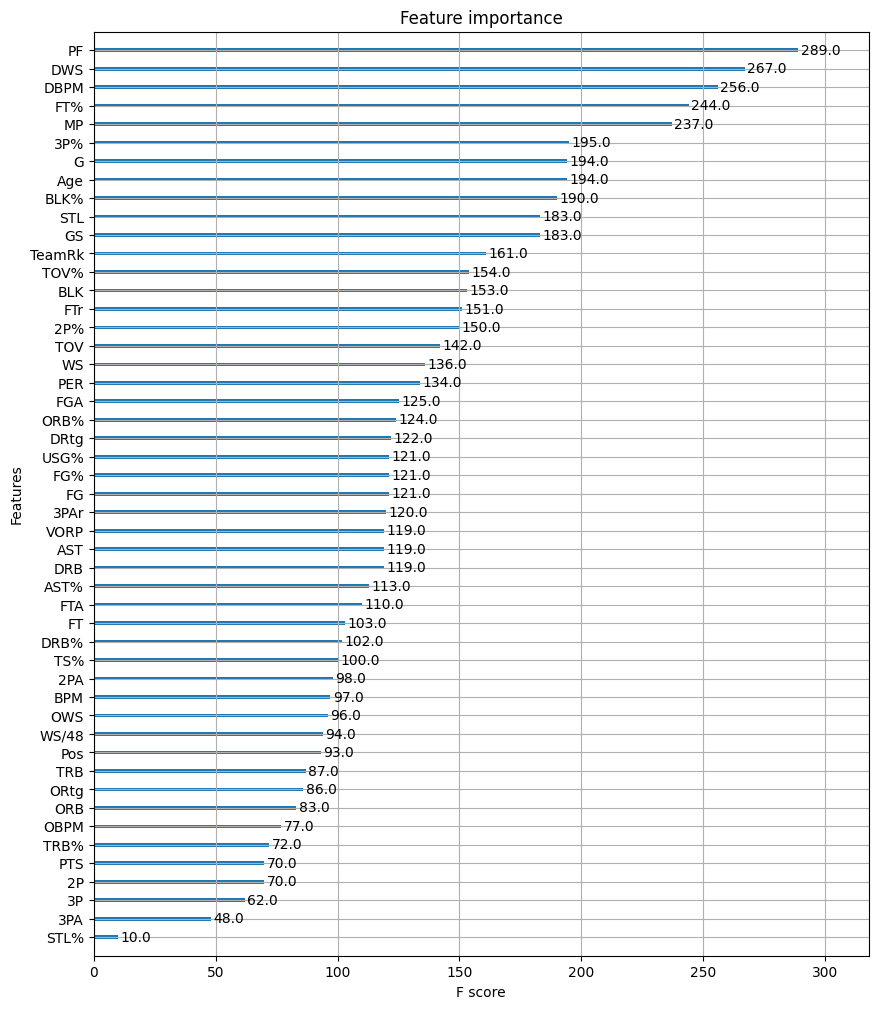

In [210]:
_, ax = plt.subplots(figsize = (10, 12))
xgb.plot_importance(tunedMod, ax = ax)

Tune threshold to maximize F1 score

In [211]:
def optimizeThreshold(model, X, y):
    best = []
    for trainIndex, testIndex in StratifiedKFold(n_splits = 5).split(X, y):
        mod = model.fit(X.iloc[trainIndex], y.iloc[trainIndex])
        res = []
        for th in np.arange(0.05, 1, 0.05):
            yPred = mod.predict_proba(X.iloc[testIndex])[:, 1] > th
            res.append((th, f1_score(y.iloc[testIndex], yPred)))
        best.append(max(res, key = operator.itemgetter(1)))

    return np.average([th for th, _ in best]).round(2), np.average([f1 for _, f1 in best])

In [212]:
bestThXGB, bestF1XGB = optimizeThreshold(tunedMod, X, y)
print(f"Average best threshold: {bestThXGB}")
print(f"Average best F1 score: {bestF1XGB}")

Average best threshold: 0.52
Average best F1 score: 0.5818320154343632


In [213]:
def withDummyPos(X):
    posFeatures = pd.get_dummies(X.Pos, drop_first = True, prefix = "pos")
    return pd.concat([X, posFeatures], axis = 1).drop("Pos", axis = 1).apply(lambda x: x.fillna(x.median()) if pd.api.types.is_numeric_dtype(x) else x)

In [214]:
modLR = LogisticRegressionCV(
    class_weight = "balanced",
    scoring = "average_precision",
    solver = "newton-cholesky",
    cv = StratifiedKFold(n_splits = 5),
    refit = True
)

modLR.fit(withDummyPos(X), y)

print(f"Average cross validation score (AUCPR): {np.average(modLR.scores_[1])}")

Average cross validation score (AUCPR): 0.4956587095465131


In [215]:
bestThLR, bestF1LR = optimizeThreshold(modLR, withDummyPos(X), y)
print(f"Average best threshold: {bestThLR}")
print(f"Average best F1 score: {bestF1LR}")

Average best threshold: 0.91
Average best F1 score: 0.5211215439871049


# Stage 2 Model

In [216]:
model2Data = model1Data.drop(["ShareBinary"], axis = 1)
model2Data = model2Data.loc[model2Data["Share"].gt(0)]
model2Data.reset_index(drop = True, inplace = True)
model2Data

,Pos,Age,G,GS,MP,FG,FGA,FG%,3P,3PA,...,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,Share
0,PG,30,70,69,2700,7.5,19.0,0.392,1.8,6.8,...,20.1,1.9,3.7,5.6,0.099,1.2,1.5,2.6,3.2,0.034
1,PF,21,82,82,3204,12.0,21.8,0.549,0.0,0.2,...,26.0,5.6,7.2,12.8,0.192,2.5,2.0,4.6,5.3,0.034
2,PF,21,82,82,3222,10.2,20.8,0.491,0.0,0.3,...,22.5,5.3,4.2,9.6,0.143,2.6,1.5,4.2,5.0,0.009
3,SF,29,81,81,2733,8.1,18.8,0.429,0.5,1.9,...,19.8,2.9,3.0,5.9,0.104,0.0,1.5,1.4,2.3,0.009
4,C,32,76,76,2803,7.7,16.8,0.459,0.0,0.1,...,16.9,3.6,3.6,7.1,0.122,0.4,0.8,1.2,2.2,0.009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
570,PF,27,76,7,2166,6.5,11.3,0.572,0.0,0.1,...,13.1,4.3,3.8,8.1,0.179,0.1,1.2,1.3,1.8,0.030
571,SG,28,77,77,2792,13.8,29.0,0.476,1.4,4.7,...,34.9,8.5,4.6,13.0,0.224,7.1,2.1,9.2,7.9,0.021
572,C,35,69,67,1975,4.3,8.0,0.541,0.0,0.1,...,10.0,2.4,2.3,4.7,0.115,0.7,1.2,1.9,1.9,0.002
573,SF,27,76,76,3119,7.8,16.1,0.484,0.9,2.4,...,20.3,5.3,6.2,11.5,0.177,1.0,1.7,2.7,3.7,0.185


In [217]:
model2Data.shape[0] == dpoyVoting.shape[0]

True

In [218]:
X = model2Data.drop(["Share"], axis = 1)
y = model2Data["Share"]

In [219]:
mod2 = xgb.XGBRegressor(
    eval_metric = "rmse",
    enable_categorical = True
)

paramsDist = {
    "learning_rate": stats.uniform(0.01, 0.20), 
    "max_depth": stats.randint(3, 12), 
    "n_estimators": stats.randint(25, 300)
}
rsMod2 = RandomizedSearchCV(
    estimator = mod2, 
    param_distributions = paramsDist, 
    scoring = "neg_root_mean_squared_error",
    n_iter = 75, 
    cv = KFold(n_splits = 5), 
    refit = True
)

rsMod2.fit(X, y)

print(f"Best parameters: {rsMod2.best_params_}")
print(f"Best cross validation score (neg RMSE): {rsMod2.best_score_}")

tunedMod2 = rsMod2.best_estimator_

Best parameters: {'learning_rate': 0.11085689886834184, 'max_depth': 3, 'n_estimators': 117}
Best cross validation score (neg RMSE): -0.1522509483754011


In [220]:
print(
    f"Average cross validation score (r2): "
    f"{np.average(cross_val_score(tunedMod2, X, y, scoring = "r2", cv = KFold(n_splits = 5)))}"
)

Average cross validation score (r2): 0.3017254375798617


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

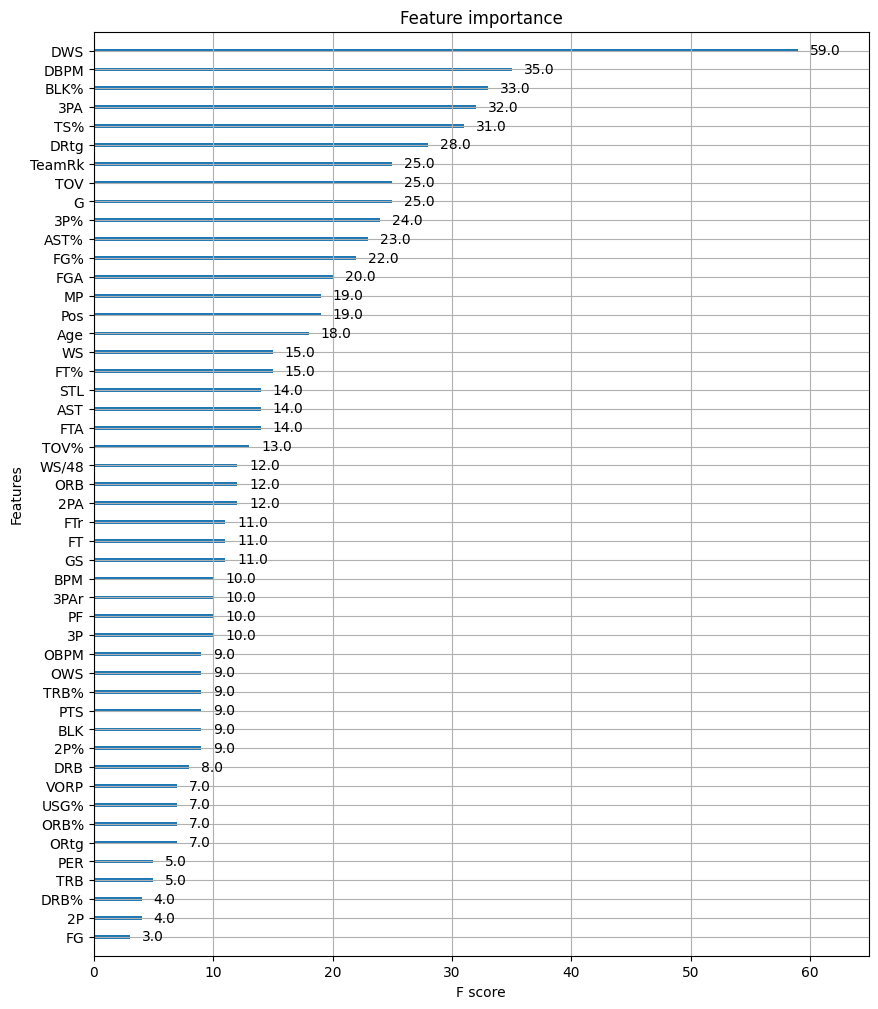

In [221]:
_, ax = plt.subplots(figsize = (10, 12))
xgb.plot_importance(tunedMod2, ax = ax)

In [222]:
modLR2 = RFECV(
    estimator = LinearRegression(),
    min_features_to_select = 1,
    step = 1,
    scoring = "neg_root_mean_squared_error",
    cv = KFold(n_splits = 5)
)

modLR2.fit(withDummyPos(X), y)

RFECV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
      estimator=LinearRegression(), scoring='neg_root_mean_squared_error')

In [223]:
print(
    f"Average cross validation score (negative RMSE): "
    f"{np.average(modLR2.cv_results_["mean_test_score"])}"
)

Average cross validation score (negative RMSE): -0.16683307507051887


In [224]:
print(
    f"Average cross validation score (r2): "
    f"{np.average(cross_val_score(modLR2, withDummyPos(X), y, scoring = "r2", cv = KFold(n_splits = 5)))}"
)

Average cross validation score (r2): 0.21111538352671927


# Predict Current Year

In [225]:
def createModelData(basic_stats, adv_stats, standings):
    basic = pd.read_csv(basic_stats)
    adv = pd.read_csv(adv_stats)
    stand = pd.read_csv(standings, header = 1)


    basic.loc[:, "Player"] = basic["Player"].map(lambda x: x.rstrip("*"))
    adv.loc[:, "Player"] = adv["Player"].map(lambda x: x.rstrip("*"))


    tmMapping = {
        "Atlanta Hawks": "ATL",
        "Boston Celtics": "BOS",
        "Brooklyn Nets": "BRK",
        "Charlotte Hornets": "CHO", 
        "Chicago Bulls": "CHI",
        "Cleveland Cavaliers": "CLE", 
        "Dallas Mavericks": "DAL",
        "Denver Nuggets": "DEN",
        "Detroit Pistons": "DET",
        "Golden State Warriors": "GSW",
        "Houston Rockets": "HOU",
        "Indiana Pacers": "IND",
        "Los Angeles Clippers": "LAC",
        "Los Angeles Lakers": "LAL",
        "Memphis Grizzlies": "MEM",
        "Miami Heat": "MIA",
        "Milwaukee Bucks": "MIL",
        "Minnesota Timberwolves": "MIN",
        "New Orleans Pelicans": "NOP",
        "New York Knicks": "NYK",
        "Oklahoma City Thunder": "OKC",
        "Orlando Magic": "ORL",
        "Philadelphia 76ers": "PHI",
        "Phoenix Suns": "PHO",
        "Portland Trail Blazers": "POR",
        "Sacramento Kings": "SAC",
        "San Antonio Spurs": "SAS",
        "Toronto Raptors": "TOR",
        "Utah Jazz": "UTA",
        "Washington Wizards": "WAS"
    }
    stand["Tm"] = stand["Team"].map(tmMapping)


    rkMapping = dict(zip(stand["Tm"], stand["Rk"]))

    def computeWeightedAverage(row):
        combos = basic.loc[(basic["Player"] == row["Player"]) & (basic["Tm"] != "TOT")]
        weights = combos["MP"] / combos["MP"].sum()
        return np.average([rkMapping[k] for k in combos["Tm"]], weights = weights)

    basic["TeamRk"] = [rkMapping[rowKey] if (rowKey := row["Tm"]) in rkMapping.keys() else computeWeightedAverage(row) for _, row in basic.iterrows()]
    

    basic.drop_duplicates(subset = "Player", keep = "first", inplace = True)
    adv.drop_duplicates(subset = "Player", keep = "first", inplace = True)


    basic.drop(["Rk", "Tm", "Unnamed: 29", "Player-additional"], axis = 1, inplace = True)
    adv.drop(["Rk", "Pos", "Age", "Tm", "G", "MP", "Unnamed: 19", "Unnamed: 24", "Player-additional"], axis = 1, inplace = True)


    combined = pd.merge(basic, adv, how = "left", on = "Player")
    combined["Pos"] = combined["Pos"].astype("category")


    return combined
    

In [226]:
def predictVoteShare(data, stage1, threshold, stage2):
    probSomeShare = stage1.predict_proba(data.drop("Player", axis = 1))[:, 1]

    noShare = data.loc[~(probSomeShare > threshold)].copy()
    noShare["Vote_Share"] = 0
    
    someShare = data.loc[probSomeShare > threshold].copy()
    someShare["Vote_Share"] = stage2.predict(someShare.drop("Player", axis = 1))

    return pd.concat([someShare[["Player", "Vote_Share"]], noShare[["Player", "Vote_Share"]]], ignore_index = True).sort_values("Vote_Share", ascending = False).reset_index(drop = True)


In [227]:
currentYear = createModelData(
    basic_stats = (pathlib.Path()/"Data"/"Current_Year"/"2023-2024_Basic_Stats.csv").resolve(),
    adv_stats = (pathlib.Path()/"Data"/"Current_Year"/"2023-2024_Adv_Stats.csv").resolve(),
    standings = (pathlib.Path()/"Data"/"Current_Year"/"2023-2024_Standings.csv").resolve()
)

In [228]:
resultsXGB = predictVoteShare(data = currentYear, stage1 = tunedMod, threshold = bestThXGB, stage2 = tunedMod2)
resultsXGB.loc[resultsXGB["Vote_Share"].gt(0)]

,Player,Vote_Share
0,Victor Wembanyama,0.500436
1,Rudy Gobert,0.270740
2,Chet Holmgren,0.189215
3,Giannis Antetokounmpo,0.155664
4,Anthony Davis,0.154864
5,Isaiah Hartenstein,0.109240
6,Kristaps Porziņģis,0.101876
7,Shai Gilgeous-Alexander,0.099163


In [238]:
def matchDummiesPos(X, XTrain):
    presentDummies = pd.get_dummies(X, prefix = "pos")
    res = pd.DataFrame()
    for d in [d for d in pd.get_dummies(XTrain, prefix = "pos").columns if d.startswith("pos_")]:
        if d in presentDummies.columns:
            res[d] = presentDummies[d]
        else:
            res[d] = False
    res.drop(columns = res.columns[0], axis = 1, inplace = True)
    return pd.concat([X, res], axis = 1).drop("Pos", axis = 1).apply(lambda x: x.fillna(x.median()) if pd.api.types.is_numeric_dtype(x) else x)

In [239]:
resultsLR = predictVoteShare(
    data = matchDummiesPos(currentYear, model1Data), 
    stage1 = modLR, 
    threshold = bestThLR, 
    stage2 = modLR2
)
resultsLR.loc[resultsLR["Vote_Share"].gt(0)]

,Player,Vote_Share
0,Markquis Nowell,0.587054
1,Hamidou Diallo,0.351448
2,Rudy Gobert,0.320541
3,Chet Holmgren,0.152164
4,Victor Wembanyama,0.147335
5,Anthony Davis,0.142825
6,Shai Gilgeous-Alexander,0.142441
7,Isaiah Hartenstein,0.130650
8,Josh Hart,0.129900
9,Nikola Jokić,0.123694
